Цель работы
- Освоить базовые принципы построения и обучения простой нейронной сети на
PyTorch.
- Научиться экспортировать модель в формат ONNX.
- Изучить структуру модели через граф вычислений с использованием
инструмента Netron

In [ ]:
!pip install --upgrade onnx onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 10.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 8.5 MB/s eta 0:00:00


# Создание кастомной нейросети

В качестве запоминания и большего понимания реализую LeNet-5

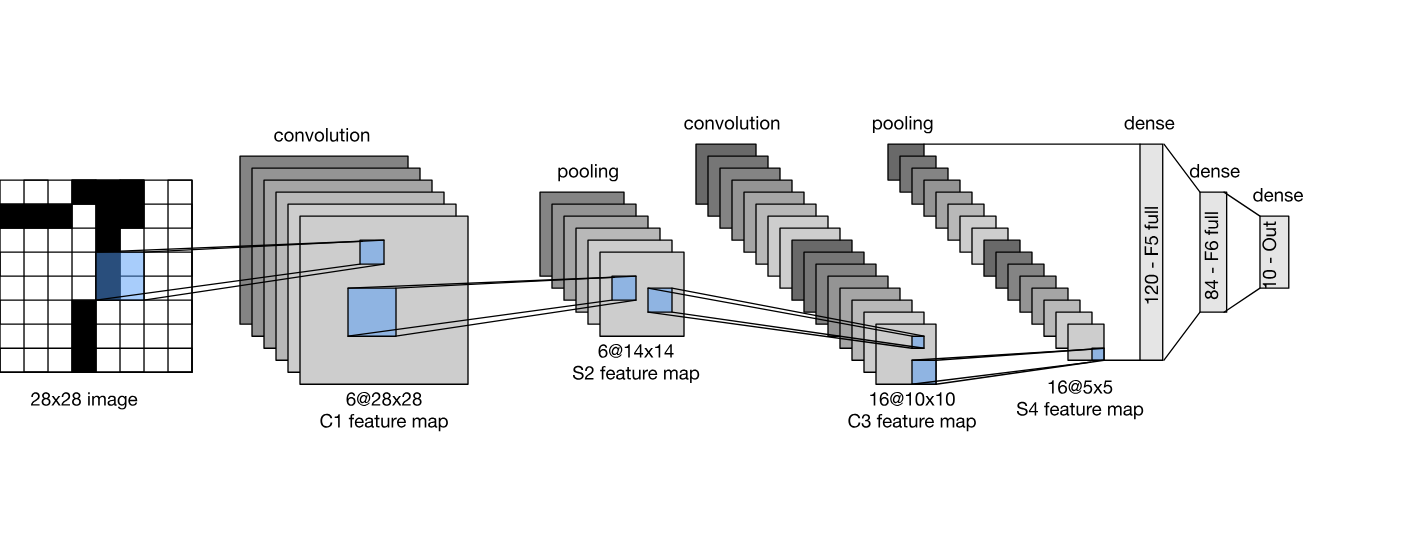

In [ ]:
# IMPLEMENTATION WITH Sequential

import torch
import torch.nn as nn


class LeNet5(nn.Module):
    def __init__(self):
        '''
        kernel_size = 5 / 2 as in original LeNet-5
        padding = 0 because LeNet-5 didn't have padding
        stride=1 step of kernel during shifting
        '''
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(
            # Input 32x32 → Conv5x5 stride1 padding0 → Output 6@28x28  (32-5+1=28)
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0, stride=1),
            nn.Tanh(),
            # Input 28x28 → Pool2x2 stride2 → Output 14x14 (28/2=14)
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Input 14x14 → Conv5x5 stride1 padding0 → Output 16@10x10  (14-5+1=10)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1),
            nn.Tanh(),
            # Input 10x10 → Pool2x2 stride2 → Output 5x5 (10/2=5)
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.linears = nn.Sequential(
            # Input 16@5x5 -> Output 400
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
            # ! Commented finall Softmnax because ONNX has problems with it !
            # nn.Softmax()
        )

    def forward(self, x):
        out = self.feature_extractor(x)
        out = torch.flatten(out, 1)
        out = self.linears(out)
        return out

In [ ]:
# IMPLEMENTATION WITHOUT Sequential

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# class LeNet5(nn.Module):
#     def __init__(self):
#         '''
#         kernel_size = 5 / 2 as in original LeNet-5
#         padding = 0 because LeNet-5 didn't have padding
#         stride=1 step of kernel during shifting
#         '''
#         super(LeNet5, self).__init__()
#         # Input 32x32 → Conv5x5 stride1 padding0 → Output 6@28x28  (32-5+1=28)
#         self.conv2d1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0, stride=1)
        
#         # Input 14x14 → Conv5x5 stride1 padding0 → Output 6@10x10  (14-5+1=10)
#         self.conv2d2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1)

#         # Input 16@5x5 -> Output 400
#         self.l1 = nn.Linear(400, 120)
#         self.l2 = nn.Linear(120, 84)
#         self.l3 = nn.Linear(84, 10)

#     def forward(self, x):
#         out = self.conv2d1(x)
#         out = F.tanh(out)
#         # Input 28x28 → Pool2x2 stride2 → Output 14x14 (28/2=14)
#         out = F.avg_pool2d(out, kernel_size=2, stride=2)

#         out = self.conv2d2(out)
#         out = F.tanh(out)
#         # Input 10x10 → Pool2x2 stride2 → Output 5x5 (10/2=5)
#         out = F.avg_pool2d(out, kernel_size=2, stride=2)

#         out = torch.flatten(out, 1)

#         out = self.l1(out)
#         out = F.tanh(out)
#         out = self.l2(out)
#         out = F.tanh(out)
#         out = self.l3(out)

#         return out

# Запуск модели и экспорт в ONNX

In [4]:
lenet_model = LeNet5()
lenet_model.eval()

dummy_input = torch.rand(1, 1, 32, 32)

In [ ]:
# Export to ONNX:
torch.onnx.export(
    lenet_model,                    # model
    dummy_input,                    # input example
    './sources/lenet5_cnn.onnx',    # save path
    input_names=['input'],          # name of input
    output_names=['output'],        # name of output
    opset_version=18,               # ONNX version
)

[torch.onnx] Obtain model graph for `LeNet5([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `LeNet5([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.1+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,1,32,32]>
            ),
            outputs=(
                %"output"<FLOAT,[1,10]>
            ),
            initializers=(
                %"feature_extractor.0.weight"<FLOAT,[6,1,5,5]>{TorchTensor(...)},
                %"feature_extractor.0.bias"<FLOAT,[6]>{TorchTensor<FLOAT,[6]>(Parameter containing: tensor([-0.0328,  0.1937,  0.0902, -0.0216,  0.1665, -0.1277], requires_grad=True), name='feature_extractor.0.bias')},
                %"feature_extractor.3.weight"<FLOAT,[16,6,5,5]>{TorchTensor(...)},
                %"feature_extractor.3.bias"<FLOAT,[16]>{TorchTensor(...)},
                %"linears.0.weight"<FLOAT,[120,400]>{TorchTensor(...

# Анализ графа вычислений в Netron


Схема сделана с помощью [Netron](https://netron.app/) и сохранена также в папке source под названием lenet5_cnn.onnx.png

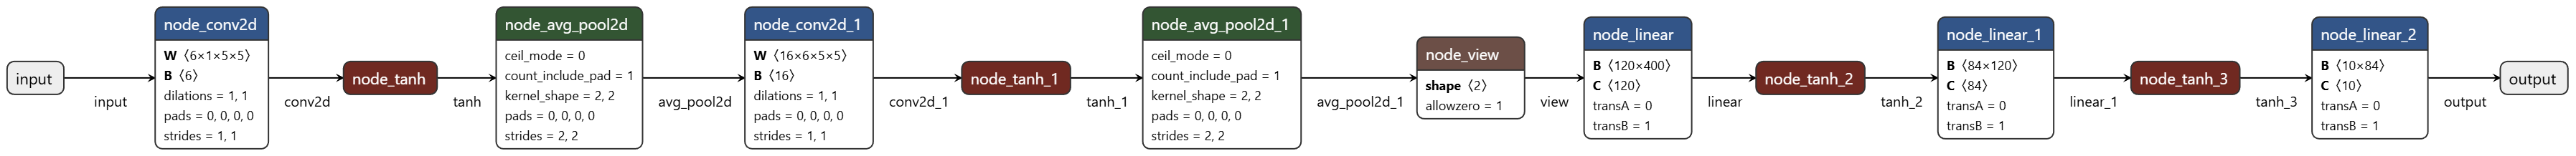
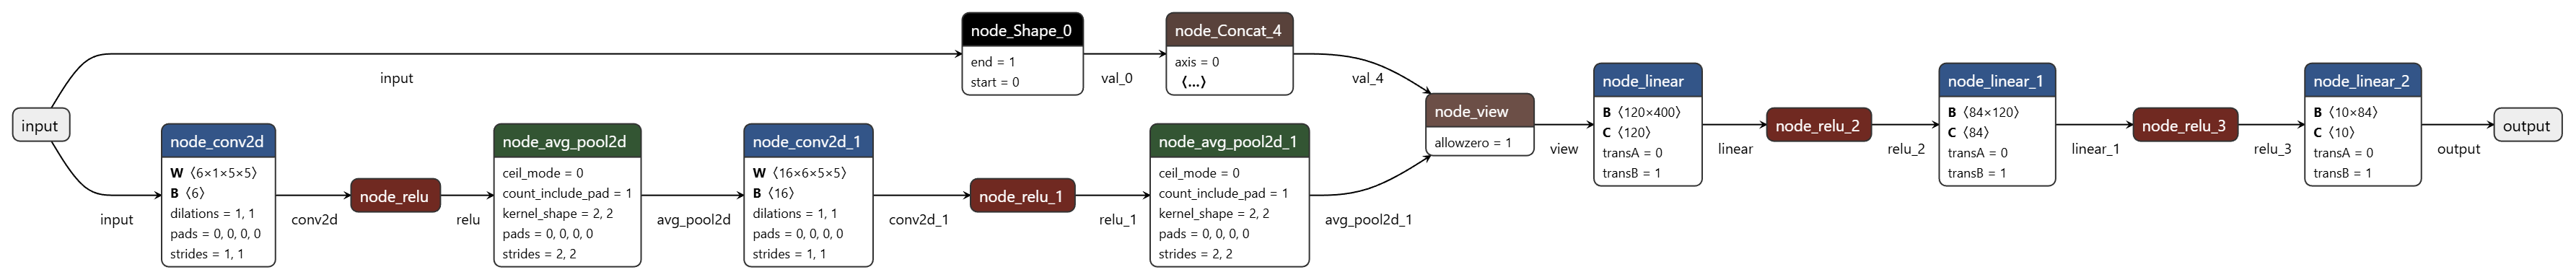

Таким образом граф отражает LeNet-5 сеть:
- **Всего слоев**: 7
    - **Сверточных слоев**: 2
        1. 6@28*28 (kernel=5, padding=0, stride=1)
        2. 16@10*10 (kernel=5, padding=0, stride=1)
    - **Пулинг слоев**: 2
        1. 6@14*14 (kernel=2, stride=2)
        2. 16@5*5 (kernel=2, stride=2)
    - **Линейных слоев**: 3
        1. 400*120
        2. 120*84
        3. 84*10
- **Функция активации**: тангенс после кадого сверточного и линейного слоев
- **[Дополнительно] Флаттен**: 1


# Контрольные вопросы

1. Сколько параметров содержится в каждом свёрточном слое?
    ```bash
    Формула подсчета параметров: 
        (in_channels × out_channels × kernel_size[0] × kernel_size[1]) + out_channels
    В первом сверточном слое -> (1*6*5*5)+6 = 156
    Во втором сверточном слое -> (6*16*5*5)+16 = 2406
    ```


2. Как влияет MaxPool2d на размер выходного тензора?
    ```bash
    MaxPool2d (как и AvgPool2d в моем случае) уменьшает пространственные размеры по формуле:
        output_size = floor((input_size + 2 x padding - kernel_size) / stride) + 1
    В первом пулинг слое -> ((28+2*0-2)/1)+1 = 14
    Во втором пулинг слое -> ((10+2*0-2)/1)+1 = 5
    ```
3. Что произойдёт при изменении количества выходных каналов в первом Conv2d?
    ```bash
    Рассмотрим на примере увеличения выходных каналов. 
    Физически:
        Пусть новый out_channels=12, тогда:
         - колиечство параметров первого слоя: (1*12*5*5)+12 = 312
         - выход первого слоя: 12@28x28
         - у второго сверточного слоя: in_channels = 12
    По сути: 
        Увеличит вычислительную сложность и объем потребляемой памяти, но потенциально повысит выразительность модели
    ```
4. Чем отличается eval() от train() режимов в PyTorch?
    ```bash
    train используется для обучения, тогда как eval - для валидации, отключая dropout и обновление running states
    ```
5. Какие преимущества даёт экспорт в формат ONNX?
    Основное преимущества - наглядность визуализации
    ```